    Image processing basics
    http://docs.scipy.org/doc/scipy/reference/ndimage.html
    http://scikit-image.org/docs/dev/api/skimage.filters.html

In [3]:
import numpy as np 
#import matplotlib.pyplot 
%pylab inline
from osgeo import gdal
import skimage
from scipy import ndimage as nd
from skimage import morphology as morph # for the disk method
import scipy.signal # for kernel convolution
from skimage import exposure # for the image stretch methods
from skimage import transform # for rotating images
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral # for denoising

Populating the interactive namespace from numpy and matplotlib


In [4]:
ds = gdal.Open('data/M3_4030seg_L2_aristcrater.tif')

<matplotlib.colorbar.Colorbar instance at 0x10c7744d0>

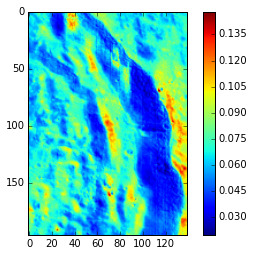

In [5]:
bnd = ds.GetRasterBand(1)
arr = bnd.ReadAsArray()
imshow(arr) #Default colormap is rainbow. That's too bad.
colorbar() 

# Colormaps
The rainbow colormap is just wrong. It's bad for people with colorblindness, and it's bad for visual understanding of quantative range. Yellows, for example, grab your attention and appear to be the most important values.

There are quite a few colormaps to choose from, but you want one that not only makes sense and looks good for your data set, but presents your data in a quantitative way. Some of following do a decent job of this. Sequential color maps generally transition from one color to another in a monotonic way.

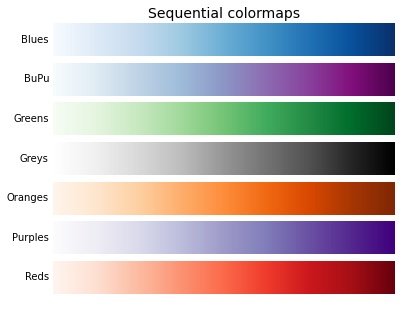

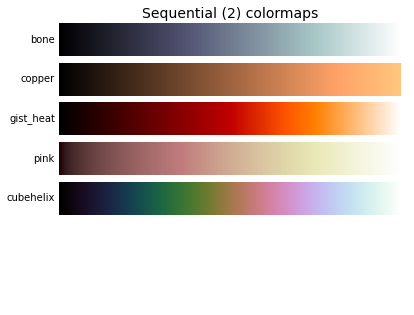

In [6]:
cmaps = [('Sequential',     ['Blues', 'BuPu', 'Greens', 'Greys', 'Oranges',
                             'Purples', 'Reds']),
         ('Sequential (2)', ['bone', 'copper',
                             'gist_heat', 'pink',
                            'cubehelix'])]
nrows = max(len(cmap_list) for cmap_category, cmap_list in cmaps)
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

def plot_color_gradients(cmap_category, cmap_list):
    fig, axes = plt.subplots(nrows=nrows)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axes, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        fig.text(x_text, y_text, name, va='center', ha='right', fontsize=10)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axes:
        ax.set_axis_off()

for cmap_category, cmap_list in cmaps:
    plot_color_gradients(cmap_category, cmap_list)

plt.show()

<matplotlib.colorbar.Colorbar instance at 0x10e9362d8>

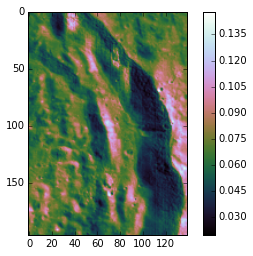

In [7]:
imshow(arr, cmap='cubehelix')
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x10ec3a560>

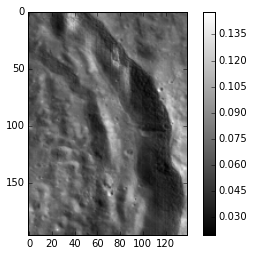

In [8]:
imshow(arr, cmap='gray')
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x10f08fb00>

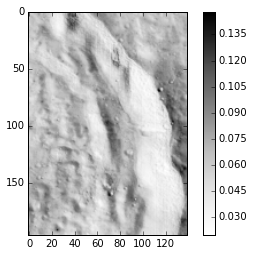

In [9]:
imshow(arr, cmap='Greys') #invert the color map...
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x10f253c20>

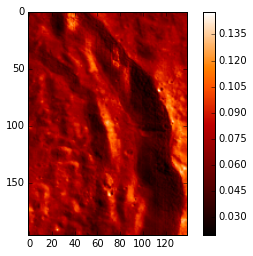

In [10]:
imshow(arr, cmap='gist_heat') #use a heatmap.
colorbar()

#Masking an image is easy.

<matplotlib.colorbar.Colorbar instance at 0x10e174a70>

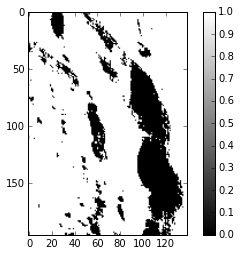

In [11]:
"""For every pixel in the image with a value greater than 0.05, immask
has a value of 1 and it has a value of 0 if the input image pixel value is less
than 0.05."""
immask = arr > 0.05
imshow(immask, cmap='gray')
colorbar() #The color bar is pretty useless when your image is binary.

In [12]:
# Apply the mask to the original image. This will zero-out every pixel
# with a value less than 0.05 and will leave every other pixel intact.
arr_msk = immask * arr 

<matplotlib.colorbar.Colorbar instance at 0x10dda3878>

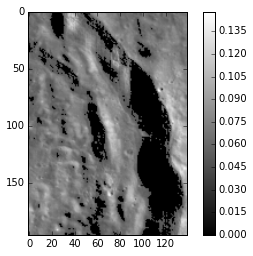

In [13]:
imshow(arr_msk, cmap='gray')
colorbar()

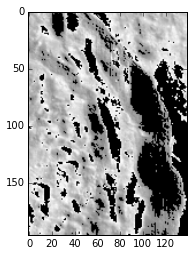

In [14]:
# You can also use the mask array to index another array

# Make a copy of the original array instead of another pointer to it.
arr2 = np.array(arr)
immask2 = arr2 < 0.045
immask5 = arr2 >= 0.085
# Mask everything above 0.045 and below 0.085.
arr2[immask2] = 0.0
arr2[immask5] = 0.0
imshow(arr2,cmap="gray")

# Contours
We can find and draw contours on images easily. 

<matplotlib.contour.QuadContourSet instance at 0x10e371560>

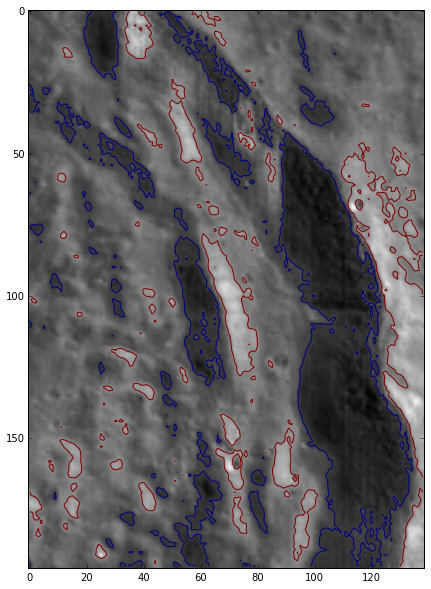

In [15]:
figsize(10,10)
plt.figure()
plt.imshow(arr, cmap='gray')
# Plot a contour around pixel values >0.09 (red).
# And plot a contour around pixel values < 0.05 (blue).
plt.contour(arr, [0.09,0.05]) 

# Filtering 
Several Python packages offer canned filters, or you can create your own
kernels to convolve with the image data.

In [16]:
#Create a lowpass kernel...
lp_box = np.empty((3,3))
lp_box[:] = 0.75 / (lp_box.shape[0]*lp_box.shape[1])
lp_box[lp_box.shape[0]/2,lp_box.shape[1]/2]=0.25
print(lp_box)

[[ 0.08333333  0.08333333  0.08333333]
 [ 0.08333333  0.25        0.08333333]
 [ 0.08333333  0.08333333  0.08333333]]


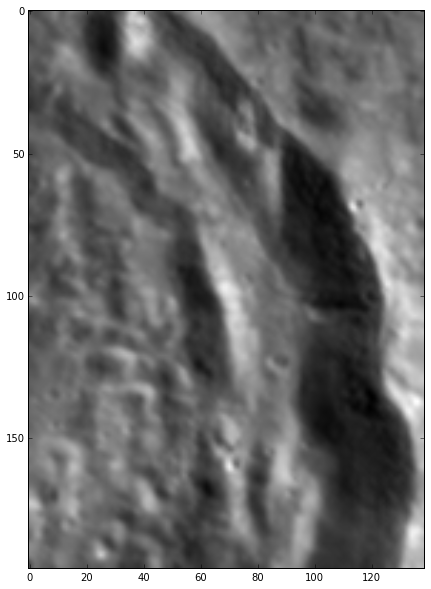

In [17]:
#Convolve the above lowpass filter with the image data.
lowpass = nd.convolve(arr,lp_box)
imshow(lowpass,cmap="gray")

 Sharpen an image by subtracting a lowpass filter and adding the result to the original image.

In [18]:
highpass = arr - lowpass

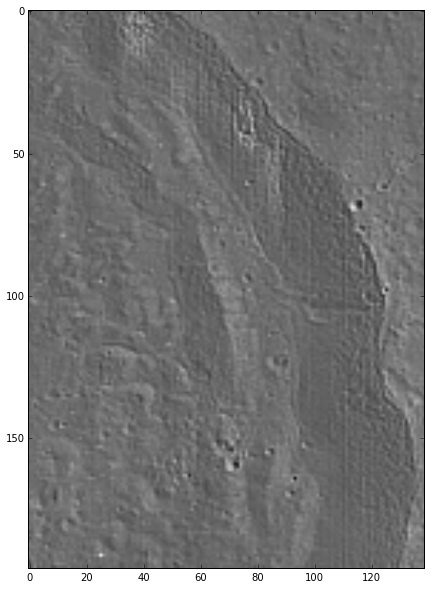

In [19]:
imshow(highpass,cmap="gray")

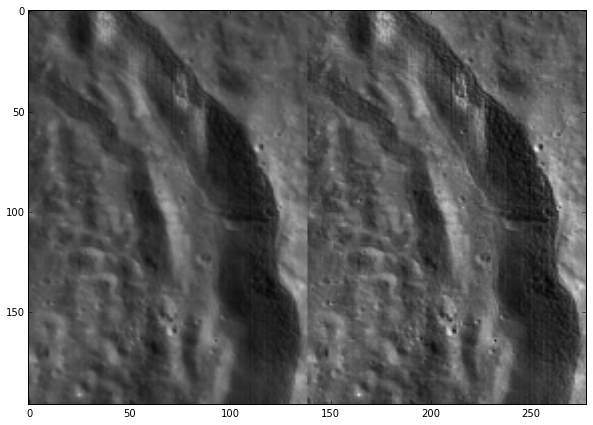

In [20]:
#Sharpen the original image by adding it back to the highpass filter.
imshow(np.hstack((arr, arr+highpass)), cmap="gray")

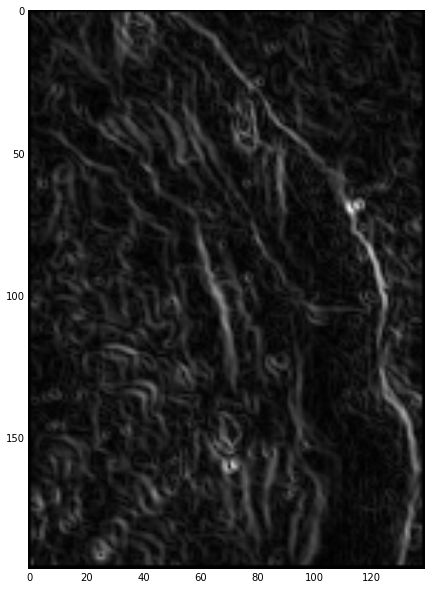

In [21]:
# You can also run pre-canned filters.
edge_sobel = skimage.filters.sobel(arr)
imshow(edge_sobel,cmap="gray")

/Users/moses/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:111: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


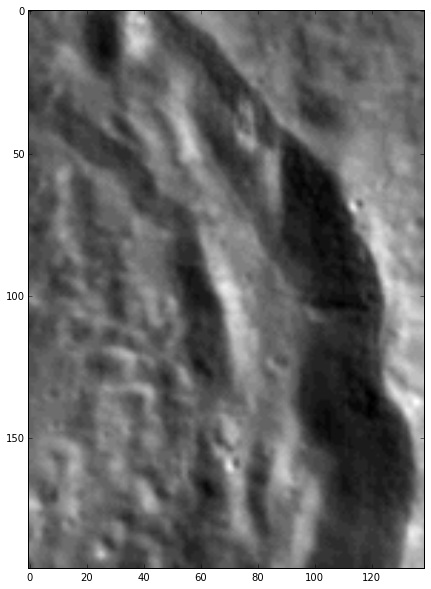

In [22]:
# We don't want to lose precision so return the box as a float array. 
box = (morph.disk(1)).astype(np.float32) 
mean = skimage.filters.rank.mean(arr,box)
imshow(mean, cmap="gray")

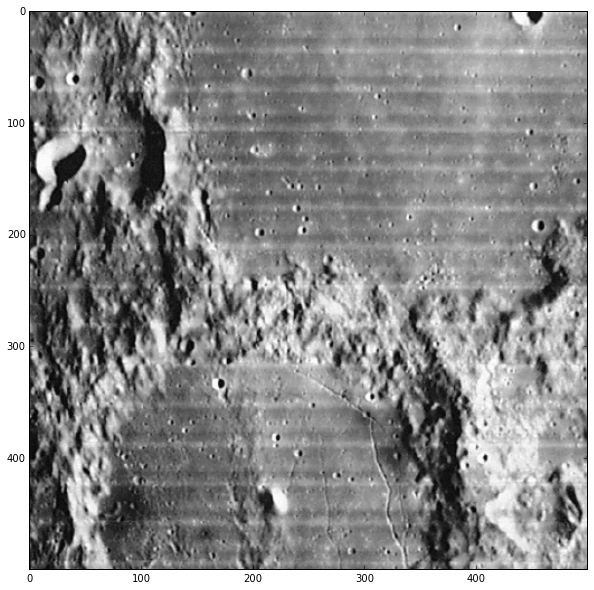

In [23]:
lo = gdal.Open("images/Striping_Noise_Sample.jpg")
loband = lo.GetRasterBand(1)
loarr = loband.ReadAsArray()
loarr = skimage.img_as_float(loarr)
imshow(loarr, cmap="gray")


# Example: destripe
* I like the convolution method in scipy.signal best. I'll use it to convolve a custom filter 
with the input image above for destriping.

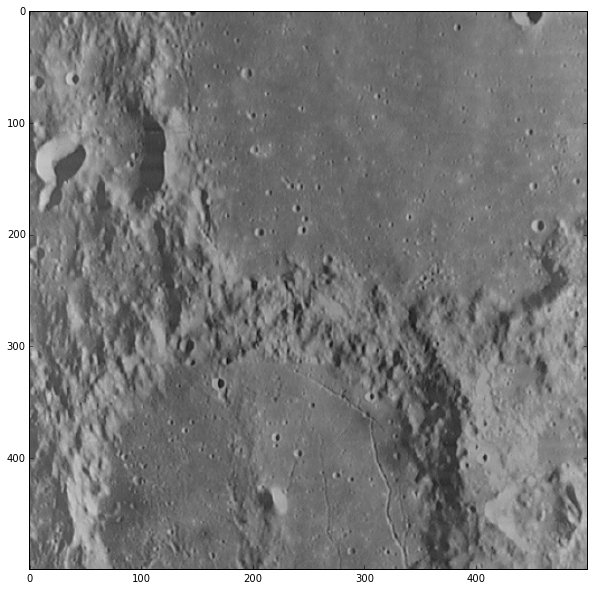

In [24]:
def destripe(image, height, width, horizontal=True):
    """
    Remove horizontal or vertical striping from an image
    
    Parameters
    ----------
    image : np.array
        The image to destripe, in the form of a numpy array
    height : int
        The approximate height of the stripes
    width : int
        The approximate width of the stripes
    horizontal : Bool
        Whether the stripes are horizontal. If False, the stripes are vertical. 
    
    Returns
    --------
    dst : np.array
        The destriped image. Contrast is decreased.
    """
    if horizontal:
        lowbox = (skimage.morphology.rectangle(height,width)).astype(np.float32)
        lowbox[:] = 0.5 / (lowbox.shape[0]*lowbox.shape[1] - 1)
        lowbox[lowbox.shape[0]/2,lowbox.shape[1]/2] = 0.5
        lowpass = scipy.signal.convolve2d(image,lowbox,mode='same')
        
        hibox = (skimage.morphology.rectangle(height/2+1,width/2+1)).astype(np.float32)
        hibox[:] = 0.5 / (hibox.shape[0]*hibox.shape[1] - 1)
        hibox[hibox.shape[0]/2,hibox.shape[1]/2] = 0.5
        hipass = image - scipy.signal.convolve2d(image,hibox,mode='same')
    else:
        lowbox = (skimage.morphology.rectangle(width,height)).astype(np.float32)
        lowbox[:] = 0.5 / (lowbox.shape[0]*lowbox.shape[1] - 1)
        lowbox[lowbox.shape[0]/2,lowbox.shape[1]/2] = 0.5
        lowpass = scipy.signal.convolve2d(image,lowbox,mode='same')
        
        hibox = (skimage.morphology.rectangle(width/2+1,height/2+1)).astype(np.float32)
        hibox[:] = 0.5 / (hibox.shape[0]*hibox.shape[1] - 1)
        hibox[hibox.shape[0]/2,hibox.shape[1]/2] = 0.5
        hipass = image - scipy.signal.convolve2d(image,hibox,mode='same')
    
    dst = image - lowpass + hipass
    return(dst)

dst_image = destripe(loarr,1,291,True)
imshow(dst_image, cmap="gray")

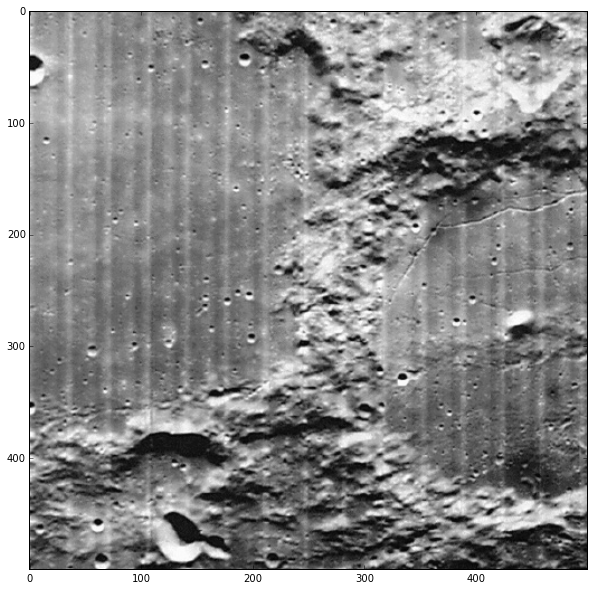

In [25]:
# Let's rotate the image 90-degrees so the striping is vertical instead of horizontal.
lorot = transform.rotate(loarr,90)
imshow(lorot, cmap="gray")

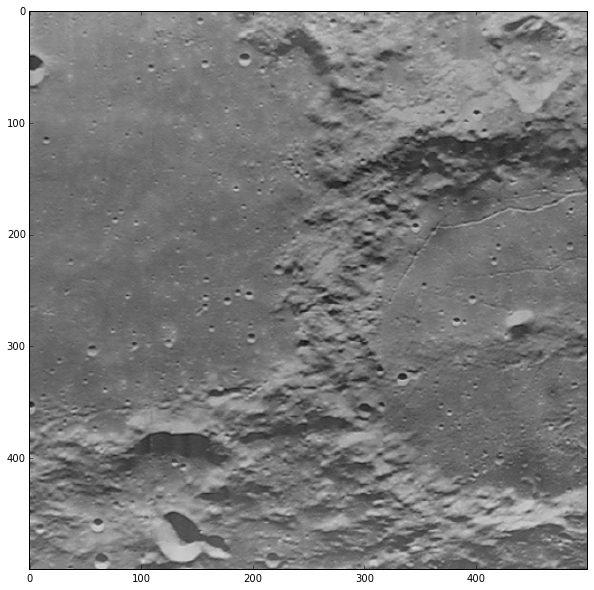

In [26]:
dst_rot = destripe(lorot,1,291,False) #Horizontal = False; the striping is vertical.
imshow(dst_rot, cmap="gray")

# Stretching
With the denoising above, contrast is lost. We can fix that by stretching the image.
Image stretching is offered through several packages.

* Stretch the image scale -- simple linear stretches are built into skimage. PyStretch also provides stretch capabilities.

In [24]:
p2, p99 = np.percentile(dst_image, (2, 99)) # Get the 2nd and 99th percentiles of the data.
str_dst = exposure.rescale_intensity(dst_image, 
                                       in_range=(p2,p99), 
                                       out_range=(0,255))

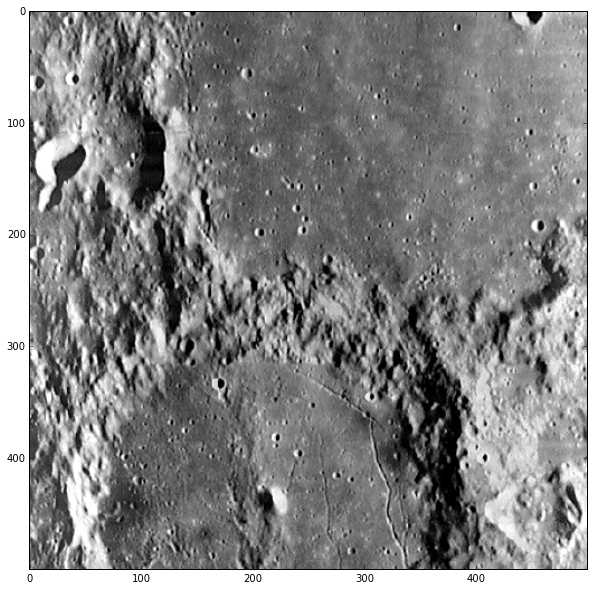

In [25]:
#imshow(np.hstack((dst_image*255, str_dst)),cmap="gray")
imshow(str_dst, cmap="gray")

#ISIS
* Open ISIS Cube -- easy with gdal.

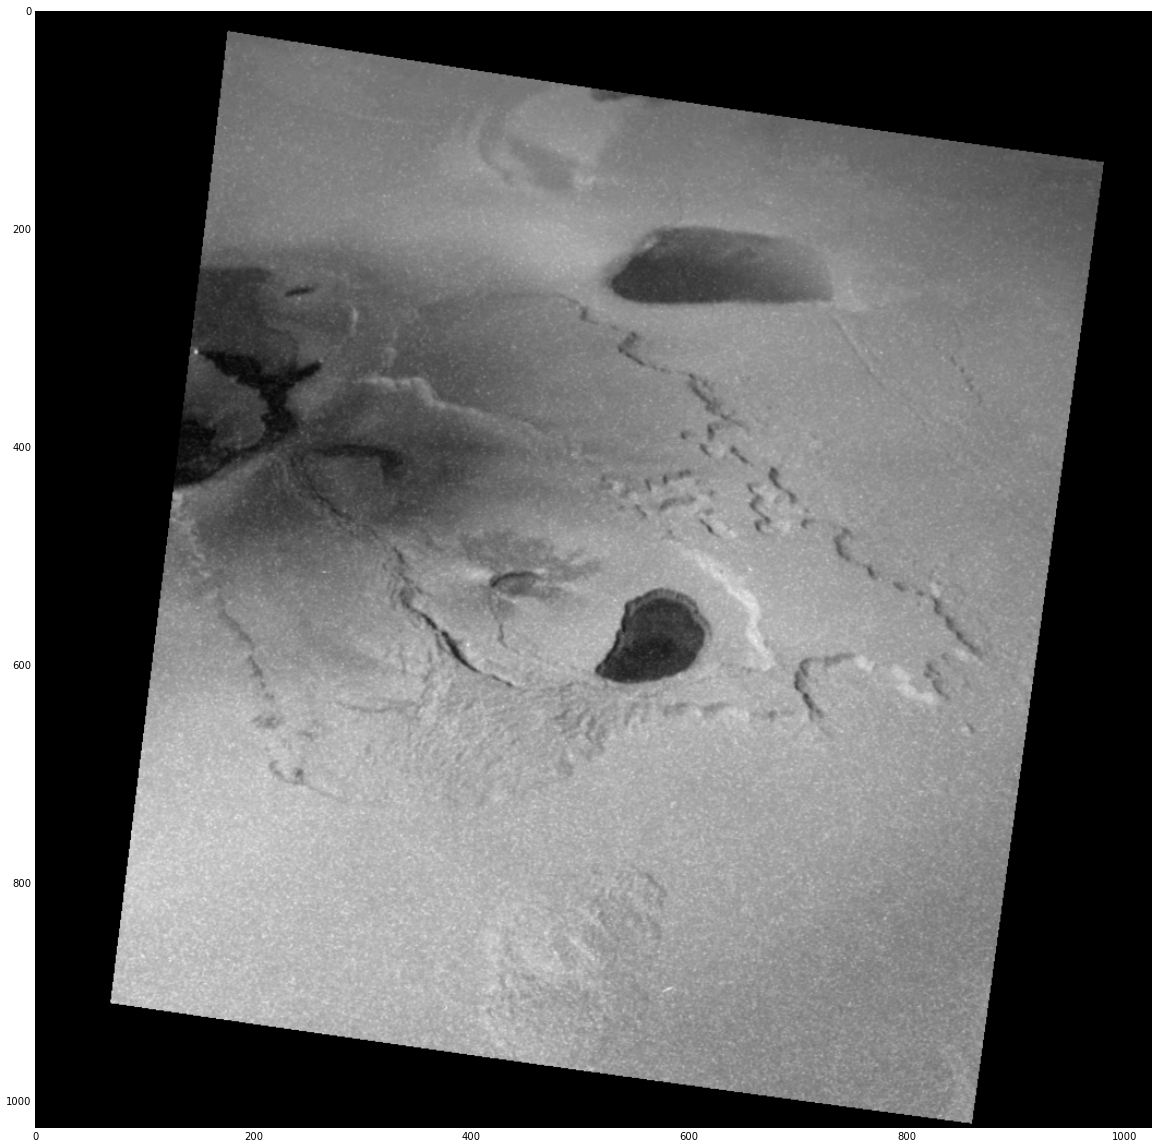

In [32]:
#Read in ISIS cubes in the same way you read in any other image data.
clr = gdal.Open('images/clr_crop.cub')
clrras = clr.GetRasterBand(1)
clrim = (clrras.ReadAsArray())
imshow(clrim, cmap="gray")

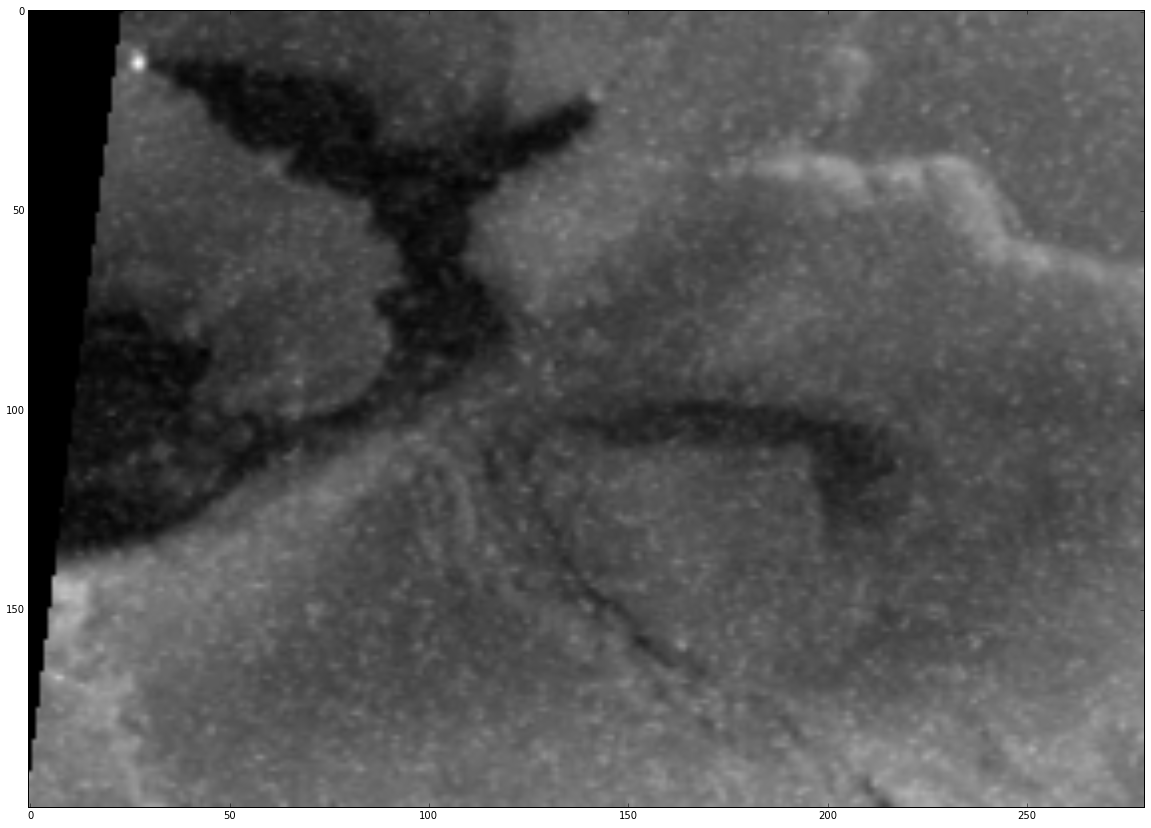

In [33]:
figsize(20,20)
imshow(clrim[300:500,120:400],cmap="gray") # Only display a subset of the image.

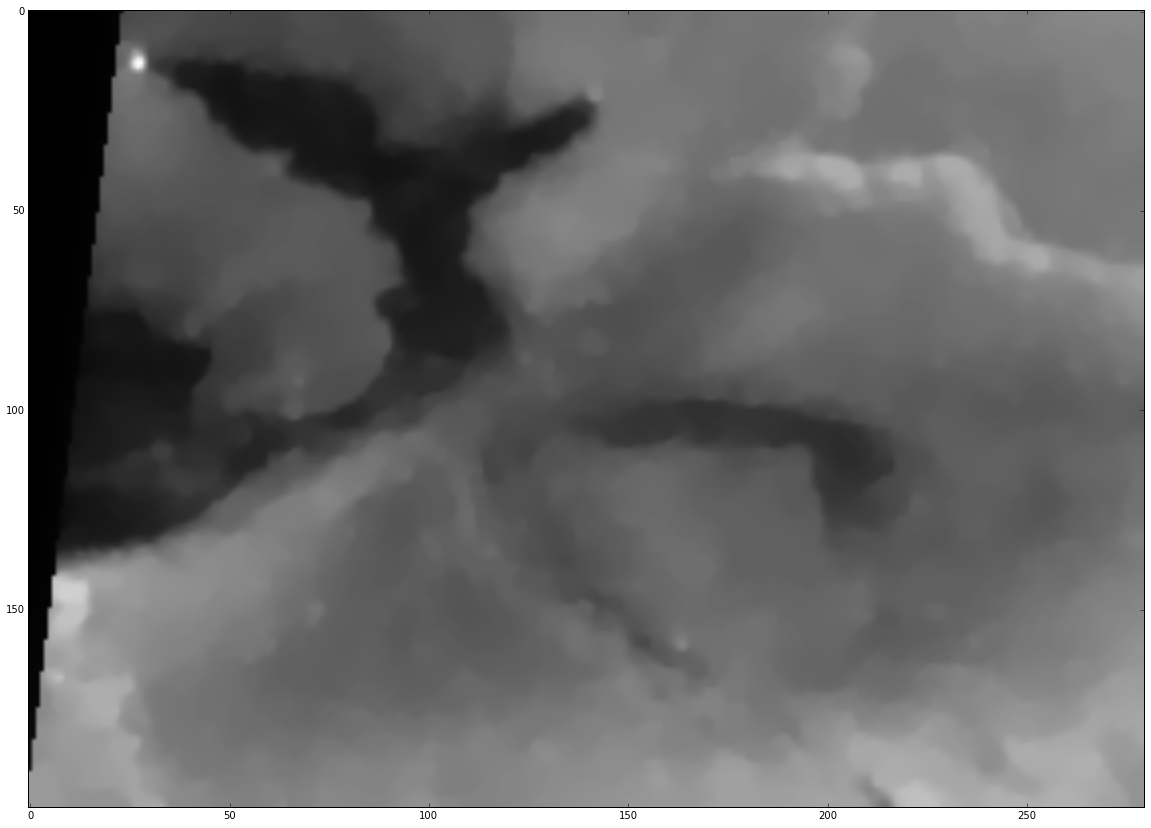

In [34]:
# The image is noisy. Clean that up. Use the chambolle filter from scikit.
imshow(denoise_tv_chambolle(clrim[300:500,120:400], weight=0.1, multichannel=True), cmap="gray")

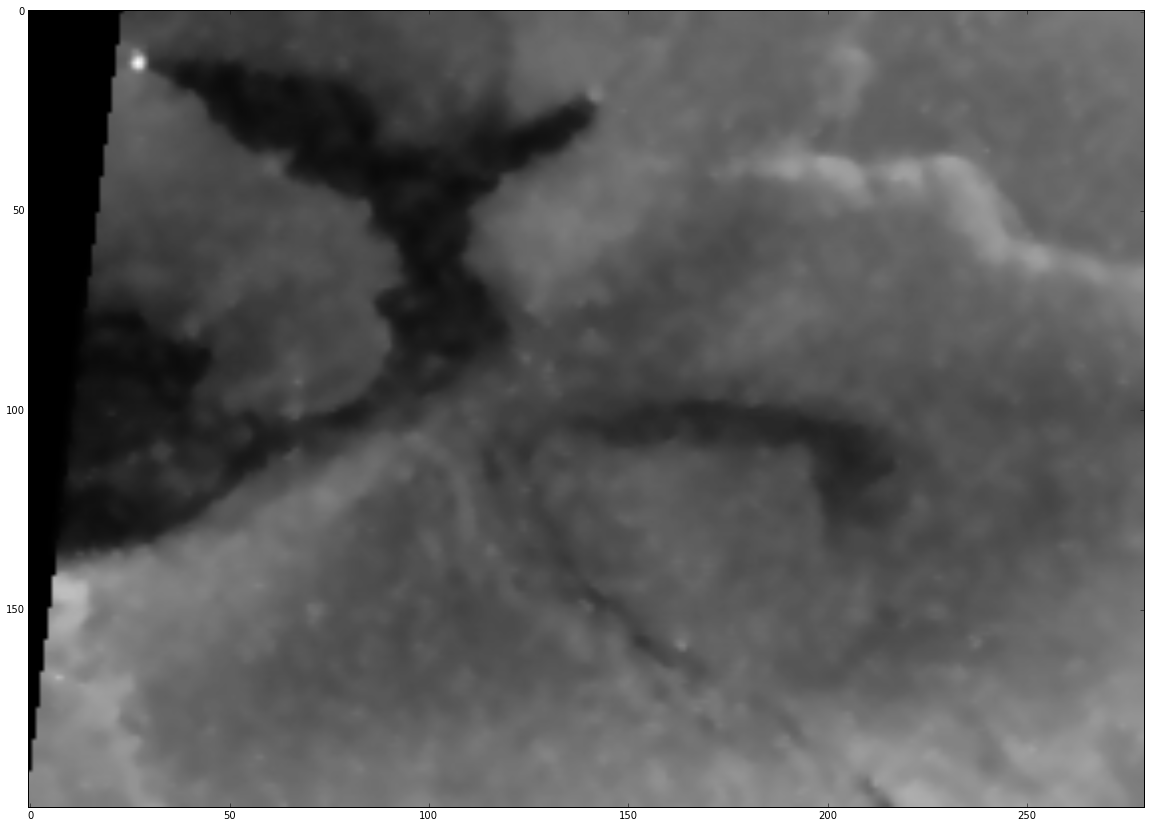

In [35]:
# Well, that doesn't look so great. Use a different denoise routine.
imshow(denoise_bilateral(clrim[300:500,120:400], sigma_range=0.07, sigma_spatial=15),cmap="gray")